In [2]:
import models as net
import utils as utls

import os
import pandas as pd
import torch
from skimage import io
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision import transforms, utils
import cv2, json, mimetypes, pdb, PIL, requests
from torch.autograd import Variable

from torchvision.models.detection import fasterrcnn_resnet50_fpn

# YOLO

In [ ]:
# to load the yolo model 
# !git clone 

In [3]:
cfg_file = 'config/yolov3.cfg'
weight_file = 'weights/yolov3.weights'
class_path = 'data/coco.names'
img_size=416

conf_thres=0.09
nms_thres=0.4
Tensor = torch.cuda.FloatTensor

In [4]:
yolo = net.Darknet(cfg_file,img_size=img_size)
yolo.load_darknet_weights(weight_file)


yolo.cuda()
yolo.eval()

class_names = utls.utils.load_classes(class_path)

In [4]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    
    return imh,imw

In [5]:
img_path = 'data/samples/dog.jpg'
img = PIL.Image.open(img_path)
imh,imw = detect_image(img)

In [6]:
img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])

In [7]:
image_tensor = img_transforms(img).float()
image_tensor = image_tensor.unsqueeze_(0)
input_img = Variable(image_tensor.type(Tensor))

In [8]:
conf_thres=0.8
nms_thres=0.4
with torch.no_grad():
        detections = model(input_img)
               
        detections = utls.utils.non_max_suppression(detections, conf_thres, nms_thres)
detections

[tensor([[ 75.3258, 119.0669, 308.8211, 291.5749,   0.9945,   0.9993,   1.0000],
         [ 70.0105, 172.5093, 168.0821, 334.7028,   0.9994,   0.9929,  16.0000],
         [261.8945,  98.0883, 372.5625, 144.2122,   0.9876,   0.9203,   7.0000]])]

# Fast_RCNN

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
Tensor = torch.cuda.FloatTensor

In [3]:
inp_w = 300
inp_h = 400

In [4]:
def detect_image(img):
    # scale image
    ratio = min(inp_w/img.size[0], inp_h/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    
    
    return imh,imw

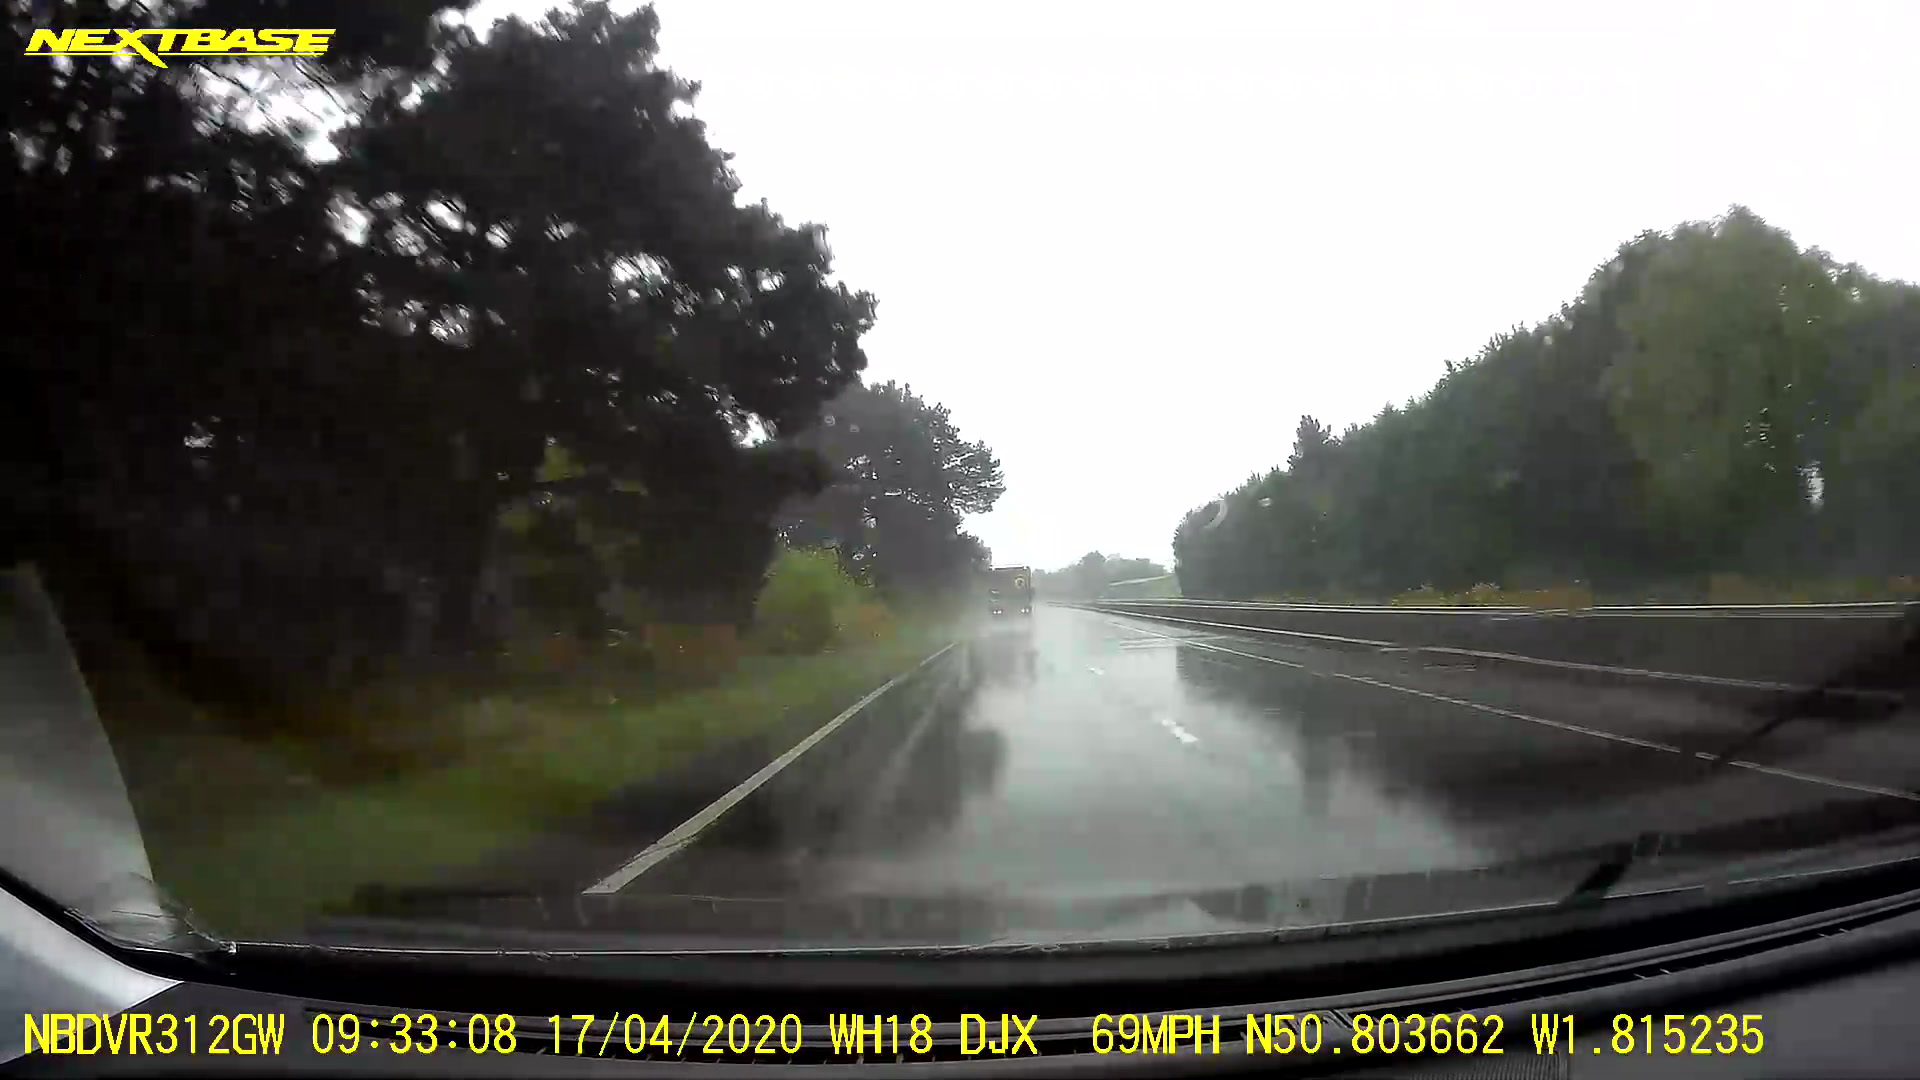

In [3]:
img_path= 'Frames/RainyDay2/00081.jpg'
img = PIL.Image.open(img_path)

img

In [6]:
img_transforms=transforms.Compose([transforms.Resize((imh,imw)), # resize, pad and transform to tensor
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])


In [8]:
from torch.autograd import Variable
torch.cuda.empty_cache()

image_tensor = img_transforms(img).float()  
image_tensor = image_tensor.unsqueeze_(0)
Tensor = torch.cuda.FloatTensor
input_img = Variable(image_tensor.type(Tensor))

input_img.size()

torch.Size([1, 3, 299, 300])

In [9]:
torch.cuda.empty_cache()

model = fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()
model.cuda()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [10]:
with torch.no_grad():
    detections = model(input_img)
detections

[{'boxes': tensor([[  4.8724, 155.3752, 298.7332, 227.5763],
          [  0.0000,  80.3226, 298.7337, 228.6552]], device='cuda:0'),
  'labels': tensor([3, 3], device='cuda:0'),
  'scores': tensor([0.1353, 0.0722], device='cuda:0')}]

In [95]:
trsh = .2

labels = detections[0]['labels'].cpu().tolist()
scores = detections[0]['scores'].cpu().tolist()

scores_ =[x for x in scores if x>trsh]
if len(scores_)!=0:
    scores_idx = scores.index(scores_[0])
    ypred = labels[score_idx:]
else:
    ypred =[]


[]

In [83]:
while x > trsh:
    
   if l[i] == 0:
       l.pop(i)
   else:
       i += 1

NameError: name 'x' is not defined

In [58]:
#score_ = pred[0]['scores'].cpu()
#score_ = [0.1353, 0.0722,0.2,.3]
#pred_score = list(score_.detach().numpy())
pred_score = [0.1353, 0.0722,0.2,.3]
#labels_= pred[0]['labels'].cpu()
labels_ = [3,4,5,6]
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels_] 

#pred_t = [pred_score.index(x) for x in pred_score if x > 0.5][-1]
pred_t =pred_score.index(max(pred_score))
pred_class = pred_class[:pred_t+1]
pred_class[:pred_t+1]

['car', 'motorcycle', 'airplane', 'bus']

In [30]:
score_ = pred[0]['scores'].cpu()
labels_= pred[0]['labels'].cpu()
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(labels_.numpy())]
pred_class

['car', 'car']

In [ ]:
# score_ = pred[0]['scores'].cpu()
# pred_score = list(score_.detach().numpy())
#pred_t = [pred_score.index(x) for x in pred_score if x > .02][-1]
pred_score.index(max(pred_score))

In [ ]:
pred_score = [20,30,40,0]

In [ ]:
pred_score = list(pred[0]['scores'].detach().numpy())

In [ ]:
pred_score

In [ ]:
threshold=0.3
pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]

In [ ]:
class_total = {'car':0,'truck':0,'bus':0,'motorcycle':0}
#class_correct = {'car':0,'truck':0,'bus':0,'motorcycle':0}
ypred = ['car', 'car', 'motorcycle', 'truck']

In [ ]:
for y_ in ypred:

    class_total[y_] +=1 

In [ ]:
class_total

In [ ]:
for p in game.players.passing():
    print p, p.team, p.passing_att, p.passer_rating()

R.Wilson SEA 29 55.7
J.Ryan SEA 1 158.3
A.Rodgers GB 34 55.8

In [ ]:
import pandas as pd
years = [2013, 2014, 2015]
dn = []
for year in years:
    df1 = pd.DataFrame({'Incidents': [ 'C', 'B','A'], year: [1, 1, 1 ],
                }).set_index('Incidents')
    dn.append(df1)
dn = pd.concat(dn, axis=1)

In [ ]:
ypred = ['car', 'car', 'motorcycle', 'truck']

In [ ]:
dn = []
for y in ypred:
    df1 = pd.DataFrame({'Incidents': [ 'C', 'B','A'],
    

In [ ]:
list1 = ['red', 'green', 'blue', 'orange', 'green', 'gray', 'green']
color_count = list1.count('green')
print('The count of color: green is ', color_count)

In [ ]:
df = {}
list1 = ['red', 'green', 'blue', 'orange', 'green', 'gray', 'green']
for k,v in df.items():
    for color in len(list1):
        df[list[color]]+=list1.count(color)
    

In [ ]:
import datetime
import pandas as pd
import numpy as np

todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=10, freq='D')

columns = ['A','B', 'C']

In [ ]:


pred = ['car', 'car', 'motorcycle', 'truck']
dn = []
for year in years:
    df1 = pd.DataFrame({'classes': ['count'],
                 year: years.count(year),
                }).set_index('classes')
    dn.append(df1)
    dn = df.loc[:,~dn.columns.duplicated()]
dn = pd.concat(dn, axis=1)

dn


In [ ]:
df = pd.DataFrame()

In [13]:
import pandas as pd
cls =['car', 'motorcycle', 'truck']
df = pd.DataFrame(0,index = cls,columns=['count'])
pred = ['car', 'car', 'motorcycle', 'truck']

df

,count
car,0
motorcycle,0
truck,0


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for i in range(4):
    label = cls[i]
    class_correct[label] += c[i]
    class_total[label] += 1

TypeError: list indices must be integers or slices, not str

In [23]:
class_correct = list(0. for i in range(10))
class_correcto0o

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
h =0
for y in cls:
    df.loc[y] +=pred.count(y)

    


df

,count
car,10
motorcycle,5
truck,5


In [ ]:
df.at[0,’Age']= 20

In [4]:
def load_ssd():
    precision = 'fp32'
    ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
    return ssd_model

In [6]:
yolo.load_ssd()

AttributeError: 'Darknet' object has no attribute 'load_ssd'

In [5]:
ssd = load_ssd()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/ehsan/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ehsan/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ssd.eval()
ssd.cuda()
ssd.to(device)

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [14]:
with torch.no_grad():
    detections = ssd(input_img)
detections

(tensor([[[ 0.4889, -0.0466,  0.1578,  ..., -0.0742, -0.0392, -0.1331],
          [ 0.2274,  0.1298, -0.1172,  ...,  0.2466,  0.3596,  0.2174],
          [-2.2568, -1.5111, -1.1295,  ...,  0.2422, -0.0114,  2.7270],
          [-1.4039, -0.9427, -1.0067,  ..., -0.8774,  0.8329, -0.7523]]],
        device='cuda:0'),
 tensor([[[ 7.8774,  8.0699,  7.7049,  ...,  6.7933,  6.6681,  7.1699],
          [ 1.3408,  1.5578,  1.3046,  ...,  0.9021,  0.7118,  0.8428],
          [-0.5774, -0.4721, -0.4922,  ..., -1.6468, -1.6470, -1.6652],
          ...,
          [-0.5877, -0.5846, -0.4529,  ..., -1.9611, -1.9547, -1.9022],
          [-0.4265, -0.4500, -0.3007,  ..., -1.6186, -1.6382, -1.5334],
          [-0.2894, -0.2377,  0.0667,  ..., -0.3775, -0.4886, -0.2724]]],
        device='cuda:0'))